In [1]:
!pip install deepxde

In [2]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from deepxde.backend import tf
import shutil
import os

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



# Import Dataset

In [3]:
import pandas as pd
raw = pd.read_csv('../Dataset/sbm1.csv')
raw = raw[0:10000]
observe_t = raw['Var1']
u_ext = raw['y1_1']
v_ext = raw['y1_2']
theta_ext = raw['y1_3']

# Formulation of the Problem

The system of ODE is written as follows:

\begin{gather*}
        \frac{d\tilde{u}}{d\tilde{t}} = \tilde{v} \\
        \frac{d\tilde{v}}{d\tilde{t}} = \kappa(v_o \tilde{t} - \tilde{u}) - \alpha(f_o + a \log \tilde{v} + b \log \tilde{\theta}) \\
        \frac{d\tilde{\theta}}{d\tilde{t}} = 1 - \tilde{v}\tilde{\theta}
    \end{gather*}

Given the measurements of $\tilde{u}, \tilde{v},$ and $\tilde{\theta}$, our goal is to predict parameter $\kappa$. We initialize parameter $\kappa$ as 0.2. True $\kappa$ is 0.25. Thus, the loss functions can be written as follows:

\begin{align*}
MSE &= MSE_R + MSE_m \\
MSE_R &= \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \left( \frac{du(t_i, \varphi)}{dt} \right) - v(t_i, \varphi) \right|^2 \\
&\quad + \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \frac{dv(t_i, \varphi)}{dt} - \kappa(v_0 t_i - u(t_i, \varphi)) + \alpha(f_o + a \log v(t_i, \varphi) + b \log \theta(t_i, \varphi)) \right|^2 \\
&\quad + \frac{1}{N_R} \sum_{i=1}^{N_R} \left| \frac{d\theta (t_i, \varphi)}{dt} - 1 + v(t_i, \varphi)\theta(t_i, \varphi) \right|^2 \\
MSE_m &= \frac{1}{N_m} \sum_{i=1}^{N_m} \left| u(t_i, \varphi) - u^*(t_i) \right|^2 + \frac{1}{N_m} \sum_{i=1}^{N_m} \left| v(t_i, \varphi) - v^*(t_i) \right|^2 + \frac{1}{N_m} \sum_{i=1}^{N_m} \left| \theta(t_i, \varphi) - \theta^*(t_i) \right|^2 \\
\end{align*}

In [4]:
alpha = 9.81
v0 = 1
f0 = 0.2
a = 0.2
b = 0.3

In [7]:
def ode_system(x, y):
  u = y[:, 0:1]
  v = y[:, 1:2]
  theta = y[:, 2:3]

  du_t = dde.grad.jacobian(y, x, i=0)
  dv_t = dde.grad.jacobian(y, x, i=1)
  dtheta_t = dde.grad.jacobian(y, x, i=2)

  return     [
      du_t - tf.clip_by_value(v,0,13) ,
      dv_t - C1 * (v0 * x - u) + alpha * (f0 + a * tf.math.log(tf.clip_by_value(v,0,13)) + b * tf.math.log(tf.clip_by_value(theta,0,11))),
      dtheta_t + (tf.clip_by_value(v,0,13) * tf.clip_by_value(theta,0,11) * tf.math.log(tf.clip_by_value(v,0,13) * tf.clip_by_value(theta,0,11)))]


# Prepare Mesurements

Apply measurements of $\tilde{u}, \tilde{v},$ and $\tilde{\theta}$ to each component

In [5]:
arr = observe_t.values
observe_t = arr.reshape((-1, 1))
u_ext = u_ext.values.reshape((-1, 1))
v_ext = v_ext.values.reshape((-1, 1))
theta_ext = theta_ext.values.reshape((-1, 1))

In [6]:
observe_y0 = dde.icbc.PointSetBC(observe_t, u_ext, component=0)
observe_y1 = dde.icbc.PointSetBC(observe_t, v_ext, component=1)
observe_y2 = dde.icbc.PointSetBC(observe_t, theta_ext, component=2)

In [8]:
def output_transform(t, y):
    y1 = y[:, 0:1]
    y2 = y[:, 1:2]
    y3 = y[:, 2:3]

    return tf.concat(
        [y1 * tf.tanh(t) + 1, y2 * tf.tanh(t) + 0.5, y3 * tf.tanh(t) + 1 ], axis=1
    )

# Define Hyperparameters and Train Model

We train from time 0 to 100. The model has 20,000 residual points, 6 hidden layers of 64 neurons with Tanh activation function, Adam optimizer with a learning rate of 0.00005. A total of 57,000 iterations were performed.

In [9]:
geom = dde.geometry.TimeDomain(0, 100)

Compiling model...
Building feed-forward neural network...
'build' took 0.097311 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 1.489674 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [2.19e-01, 1.85e+02, 9.82e-02, 3.52e+03, 7.89e+00, 2.11e+01]    [2.19e-01, 1.85e+02, 9.82e-02, 3.52e+03, 7.89e+00, 2.11e+01]    []  
1000      [7.00e-01, 2.06e+01, 1.38e+00, 2.50e+03, 7.82e+00, 9.18e+00]    [6.95e-01, 2.06e+01, 1.38e+00, 2.50e+03, 7.82e+00, 9.18e+00]    []  
2000      [2.31e-01, 7.14e+00, 9.90e-01, 2.20e+03, 8.02e+00, 9.66e+00]    [2.29e-01, 7.14e+00, 9.90e-01, 2.20e+03, 8.02e+00, 9.66e+00]    []  
3000      [3.39e-01, 3.64e+00, 3.85e-01, 1.97e+03, 8.06e+00, 9.06e+00]    [3.38e-01, 3.64e+00, 3.84e-01, 1.97e+03, 8.06e+00, 9.06e+00]    []  
4000      [5.37e-01, 2.22e+00, 1.09e-01, 1.77e+03, 8.13e+00, 8.98e+00]    [5.37e-01, 2.22e+00, 1.09e-01, 1.77e+03, 8.13e+00, 8.98e+00]    []  
5000      [8.04e-01, 1.44e+00, 8.22e-02, 1.59e+03, 8.25e+00, 8.88e+00]    [8.03e-01, 1.44

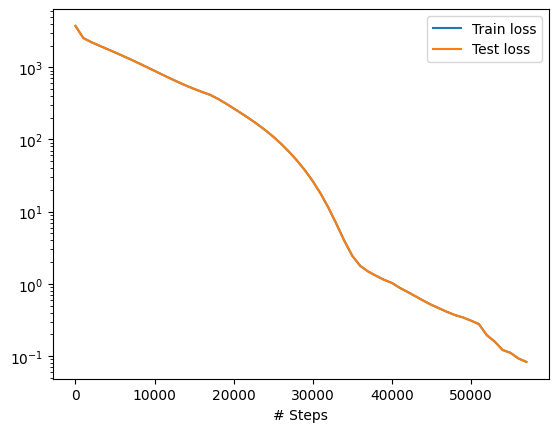

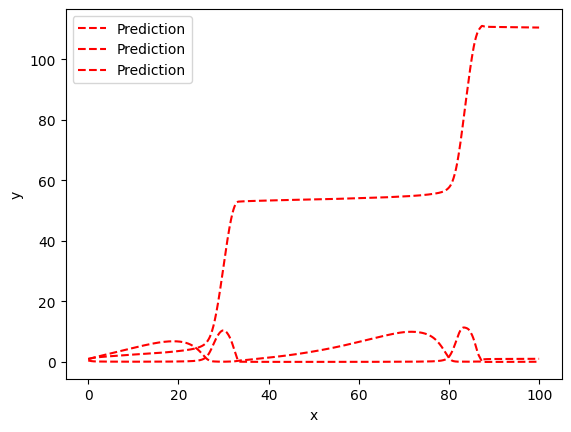

In [10]:
C1 = dde.Variable(0.2)
data = dde.data.PDE(geom, ode_system, [observe_y0, observe_y1, observe_y2], 20000, 0, num_test = 3000, anchors=observe_t)
layer_size = [1] + [64] * 6 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)
net.apply_output_transform(output_transform)
model = dde.Model(data, net)
external_trainable_variables = [C1]
variable = dde.callbacks.VariableValue(
    external_trainable_variables, period=600, filename="variables.dat"
)

model.compile(
    "adam", lr=0.00005, external_trainable_variables=external_trainable_variables
)
losshistory, train_state = model.train(iterations=57000 , callbacks=[variable], model_save_path = "model/model.ckpt")

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


# Prediction and Plotting

The predictions from output neurons are plotted below, while the prediction of $\kappa$ can be found in file "variables.dat"

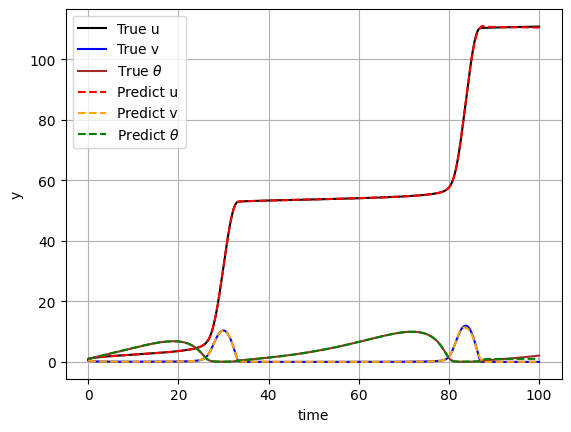

In [11]:
plt.figure()
plt.xlabel("time")
plt.ylabel("y")

plt.plot(observe_t, u_ext, color="black", label="True u")
plt.plot(observe_t, v_ext, color="blue", label="True v")
plt.plot(observe_t, theta_ext, color="brown", label=r'True $\theta$')

t = np.linspace(0, 100, 10000)
t = t.reshape(10000, 1)
sol_pred = model.predict(t)
u_pred = sol_pred[:, 0:1]
v_pred = sol_pred[:, 1:2]
theta_pred = sol_pred[:, 2:3]

plt.plot(t, u_pred, color="red", linestyle="dashed", label="Predict u")
plt.plot(t, v_pred, color="orange", linestyle="dashed", label="Predict v")
plt.plot(t, theta_pred, color="green", linestyle="dashed", label=r"Predict $\theta$")
plt.legend()
# plt.xlim([20,40])
# plt.ylim([0,100])
plt.grid()
plt.savefig('pred.png')
plt.show()